In [1]:
#import libraries
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import pandas as pd
import math

In [2]:
targets = ['comp.graphics', 'sci.space']
train = fetch_20newsgroups(subset='train', categories=targets, shuffle=True, random_state=42) 
# train

In [3]:
list(train.target_names) #target names

['comp.graphics', 'sci.space']

In [4]:
len(train.target) 

1177

In [5]:
train.target[:10]

array([0, 1, 0, 1, 1, 0, 0, 1, 0, 0], dtype=int64)

In [6]:
#imports for data cleaning
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\demet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#train.data

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
from nltk.stem.porter import PorterStemmer

#data cleaning for stemmer,numbers,punctuations..
def clear_(d):
    for i in range(len(d)):
        t=""
        d[i]=d[i].replace("\n", " ")
        d[i]=d[i].replace("\t", " ")
        punctuations = '''!()-[]{};:'"\,<>/?|=#$%^+&*_~'''
        for character in punctuations:
            d[i]=d[i].replace(character, " ")

        for word in d[i].split():
            num=False

            for h in ["0","1","2","3","4","5","6","7","8","9","@"]:
                if h in word.lower():
                    num=True
            word=word.replace(".", "")
            for x in ["cc","from","re","lines","subject","sender","nntp","posting","host","phone","fax","email"]:
                if x == word.lower(): 
                    num=True    
            word=PorterStemmer().stem(word)
            if num==False:
                t=t+" "+word
        d[i]=t
    return d

In [10]:
train.data=clear_(train.data) #clean train data

In [11]:
train.data[0] #example of clean data

' allen B thine algorithm organ purdu univers In articl kevin shin write I am tri obtain program to preprocess handwrit charact like thine algorithm graph alogrithm Do anyon know where I can obtain those I usual use algorithm for graphic and imag process by theodosio pavlidi but other peopl here got them same idea and now of copi in the librari have been stolen anoth refer is digit imag process by gonzalez and wintz wood which is wide avail but a littl expens here I just check today  ab'

In [12]:
count_vect = CountVectorizer(stop_words='english', lowercase=True)
X_train_counts = count_vect.fit_transform(train.data)
X_train_counts.shape

(1177, 13803)

In [13]:
test = fetch_20newsgroups(subset='test', categories=targets, shuffle=True, random_state=42) #read test data

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(1177, 13803)

In [15]:
df_train2=pd.DataFrame(X_train_tf.toarray(),columns=count_vect.get_feature_names()) #convert df

In [16]:
# choose 40 feature(word) the most impact on the target
df_train2["tar_"]=train.target
colmns=df_train2.corr().abs()["tar_"].sort_values(ascending=False)[:40]
df_train2=df_train2[colmns.index]
df_train2.drop("tar_",axis=1, inplace=True)

In [17]:
#convert to binary (include the word or not)
for each in df_train2.columns:
    df_train2[each]=[0 if i==0 else 1 for i in df_train2[each]]

In [18]:
class Node:
    def __init__(self):
        self.childs=[]
        self.key=None #attribute names
        self.depth=None #depth
        self.category=[] #for unique values of attributes

In [19]:
#entropy, x:attribute name, y:newsgroup
def ent(df1,x,y):
    summ=0
  #a for pEach0*math.log2(pEach0) b for pEach1*math.log2(pEach1)
    a=0
    b=0 
    for each in df1[x].unique():
        pEach=len(df1[df1[x]==each])/len(df1)
        pEach0=len(df1[(df1[x]==each) & (df1[y]==0)])/len(df1[df1[x]==each])
        pEach1=len(df1[(df1[x]==each) & (df1[y]==1)])/len(df1[df1[x]==each])
        if pEach0!=0:
            a=pEach0*math.log2(pEach0)
        if pEach1!=0:
            b=pEach1*math.log2(pEach1)
        summ+= -(pEach*(a+b))        
    return summ #h(x)

In [20]:
#information gain(x,s)= hs-hx

def info_gain(df,y):
    hs=0
    #probabilities for class entropy
    if len(df[df[y]==0])>0 and len(df[df[y]==1])>0:
        p0=len(df[df[y]==0])/len(df)
        p1=len(df[df[y]==1])/len(df)
        hs=-(p0*math.log2(p0)+ p1*math.log2(p1))

    elif len(df[df[y]==0])<=0 and len(df[df[y]==1])>0:
    #class entropy
        p1=len(df[df[y]==1])/len(df)
        hs=-(p1*math.log2(p1))
    elif len(df[df[y]==0])>0 and len(df[df[y]==1])<=0:
        p0=len(df[df[y]==0])/len(df)
        hs=-(p0*math.log2(p0))

    #information gains of each attributes
    info_gain={}
    for each in df.iloc[:,:-1].columns:
        hx=ent(df,each,y)
        info_gain[each]=hs-hx
    #return attribute with max information gain    
    return sorted(info_gain.items(), key=lambda item: item[1])[-1][0]


In [21]:
#y: "newsgroup"
def decisiontree_(df1,y_train,y,maxd):
    df=df1.copy()
    df[y]=y_train

    data=info_gain(df,y) #return attribute with max info. gain

    root=Node() #root node of tree
    root.key=data #attribute with max info. gain or min gini
    root.depth=1
    for each in df[root.key].unique():
        tree_insert(root,df,each,y,maxd)
        root.category.append(each) 
    return root

def tree_insert(parent,df,each,y,maxd):

    node=Node() #create new node
    df_new=df[df[parent.key]==each]
    df_new=df_new.drop([parent.key], axis=1)
    #if all 0 or 1 
    if len(df_new[y].unique())==1:
        node.key=df_new[y].unique()[0]
        parent.childs.append(node)
    #there are still different values(0 and 1) 
    else:
      #max depth
        if parent.depth==maxd:
            node.key=df_new[y].value_counts().index[0] # predict has max value counts
            parent.childs.append(node)
        #continue to fill tree
        else:
            
            node.key=info_gain(df_new,y) #return attribute with max info. gain
            node.depth=parent.depth+1
            parent.childs.append(node)

            for ii in df_new[node.key].unique():
                tree_insert(node,df_new,ii,y,maxd)
                node.category.append(ii)

In [22]:
def show(r,bosluk): #tree print
    
    bosluk+=1
    c=0
    for each in r.childs:
        if bosluk==1:
            print(r.key)
        if (each.key!=1) and (each.key!=0):
            print("        " *bosluk," = ",r.category[c] ,"|",each.key)
            show(each,bosluk)
        else:
            print("        " *bosluk," = ",r.category[c],":",each.key)
        c+=1
    

In [23]:
#create models with different max depth values

r=[]

for each in [4,5,6,7,8,9,10,11,12,13,17,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]:
    r.append(decisiontree_(df_train2,train.target,"newsgroup",each))


In [24]:
#show tree for max depth=4
bosluk=0            
show(r[0],bosluk)   

space
          =  0 | graphic
                  =  1 | moon
                          =  0 | imag
                                  =  1 : 0
                                  =  0 : 0
                          =  1 : 1
                  =  0 | orbit
                          =  0 | pat
                                  =  0 : 0
                                  =  1 : 1
                          =  1 : 1
space
          =  1 | graphic
                  =  0 | file
                          =  0 | color
                                  =  0 : 1
                                  =  1 : 1
                          =  1 | nasa
                                  =  1 : 1
                                  =  0 : 0
                  =  1 | lunar
                          =  0 | launch
                                  =  0 : 0
                                  =  1 : 0
                          =  1 : 1


In [25]:
#show tree for max depth=6
bosluk=0            
show(r[2],bosluk)   

space
          =  0 | graphic
                  =  1 | moon
                          =  0 | imag
                                  =  1 : 0
                                  =  0 | code
                                          =  1 : 0
                                          =  0 | file
                                                  =  1 : 0
                                                  =  0 : 0
                          =  1 : 1
                  =  0 | orbit
                          =  0 | pat
                                  =  0 | moon
                                          =  0 | flight
                                                  =  0 : 0
                                                  =  1 : 1
                                          =  1 : 1
                                  =  1 | packag
                                          =  1 : 0
                                          =  0 | card
                                                  =  0 : 1
   

In [26]:
#clear test data
test.data=clear_(test.data)
x_test_counts=count_vect.transform(test.data)
df_test=pd.DataFrame(x_test_counts.toarray(),columns=count_vect.get_feature_names())
df_test=df_test[df_train2.columns]
df_test.head()

,space,graphic,orbit,file,nasa,moon,wa,year,launch,thank,...,format,articl,day,cost,pleas,spacecraft,dure,mission,earth,card
0,2,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,7,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [27]:
def predict(each,rt):

    while (rt.key!=0) and (rt.key!=1): #until it is last node, continue
        # print(each[rt.key])
        try:
            ind=rt.category.index(each[rt.key])
        except:
            ind=0
        rt=rt.childs[ind]
    return rt.key  

In [28]:
#convert test data to binary
for each in df_test.columns:
    df_test[each]=[0 if i==0 else 1 for i in df_test[each]]



In [29]:
#predict test values
preds=[]
for x in range(len(r)):
    y_pred=[]
    for i,row in df_test.iterrows():
        y_pred.append(predict(row,r[x])) 
    preds.append(y_pred)

In [30]:
from sklearn.metrics import accuracy_score

In [31]:
#calculate accuracy
acc_tst=[]

mxdpth=4 #test
for x in range(len(preds)):
    ac=accuracy_score(test.target,preds[x])
    acc_tst.append(ac)
    print("max depth: ",mxdpth," accuracy: ",ac)
    mxdpth+=1


max depth:  4  accuracy:  0.8071519795657727
max depth:  5  accuracy:  0.8212005108556832
max depth:  6  accuracy:  0.8237547892720306
max depth:  7  accuracy:  0.842911877394636
max depth:  8  accuracy:  0.842911877394636
max depth:  9  accuracy:  0.8531289910600255
max depth:  10  accuracy:  0.8531289910600255
max depth:  11  accuracy:  0.8492975734355045
max depth:  12  accuracy:  0.8582375478927203
max depth:  13  accuracy:  0.8659003831417624
max depth:  14  accuracy:  0.8722860791826309
max depth:  15  accuracy:  0.8684546615581098
max depth:  16  accuracy:  0.8710089399744572
max depth:  17  accuracy:  0.8722860791826309
max depth:  18  accuracy:  0.8748403575989783
max depth:  19  accuracy:  0.876117496807152
max depth:  20  accuracy:  0.8722860791826309
max depth:  21  accuracy:  0.8735632183908046
max depth:  22  accuracy:  0.8735632183908046
max depth:  23  accuracy:  0.8735632183908046
max depth:  24  accuracy:  0.8735632183908046
max depth:  25  accuracy:  0.87356321839080

In [32]:
#predict train values
prd_t=[]
for x in range(len(r)):
    y_pred=[]
    for i,row in df_train2.iterrows():
        y_pred.append(predict(row,r[x]))
    prd_t.append(y_pred)


#calculate train accuracy
acc_tr=[]
mxdpth=4 
for x in range(len(prd_t)):
    ac=accuracy_score(train.target,prd_t[x])
    acc_tr.append(ac)
    print("max depth: ",mxdpth," accuracy: ", ac)
    mxdpth+=1

max depth:  4  accuracy:  0.8360237892948174
max depth:  5  accuracy:  0.8691588785046729
max depth:  6  accuracy:  0.8946474086661003
max depth:  7  accuracy:  0.9107901444350043
max depth:  8  accuracy:  0.9107901444350043
max depth:  9  accuracy:  0.9201359388275276
max depth:  10  accuracy:  0.9218351741716228
max depth:  11  accuracy:  0.9252336448598131
max depth:  12  accuracy:  0.9328802039082413
max depth:  13  accuracy:  0.9405267629566695
max depth:  14  accuracy:  0.9583687340696686
max depth:  15  accuracy:  0.9507221750212405
max depth:  16  accuracy:  0.9549702633814783
max depth:  17  accuracy:  0.9583687340696686
max depth:  18  accuracy:  0.9634664401019541
max depth:  19  accuracy:  0.9685641461342396
max depth:  20  accuracy:  0.973661852166525
max depth:  21  accuracy:  0.9745114698385726
max depth:  22  accuracy:  0.9745114698385726
max depth:  23  accuracy:  0.9753610875106202
max depth:  24  accuracy:  0.9753610875106202
max depth:  25  accuracy:  0.975361087510

In [33]:
#use decision tree in sklearn
from sklearn import tree

for each in [4,5,6,7,8,9,10,11,12,13,17,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]:
    model = tree.DecisionTreeClassifier(criterion="entropy",max_depth=each)  #with information gain
    clf = model.fit(df_train2,train.target)
    y_p=clf.predict(df_test)
    print(accuracy_score(test.target, y_p))

0.8058748403575989
0.8199233716475096
0.8275862068965517
0.8441890166028098
0.842911877394636
0.8569604086845466
0.855683269476373
0.855683269476373
0.8633461047254151
0.8480204342273308
0.8671775223499362
0.8403575989782887
0.8467432950191571
0.8684546615581098
0.8505747126436781
0.8620689655172413
0.8620689655172413
0.8582375478927203
0.8620689655172413
0.8684546615581098
0.8659003831417624
0.8710089399744572
0.8633461047254151
0.8671775223499362
0.8646232439335888
0.8646232439335888
0.8659003831417624


In [34]:
# from sklearn.pipeline import Pipeline
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.feature_extraction.text import TfidfTransformer
# text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),('tfidf', TfidfTransformer()),('clf', DecisionTreeClassifier(criterion="entropy"))])
# text_clf.fit(train.data, train.target)
# f=text_clf.predict(test.data)
# accuracy_score(test.target, f)

In [35]:
#graph for accuracies with max depths
import matplotlib.pyplot as plt

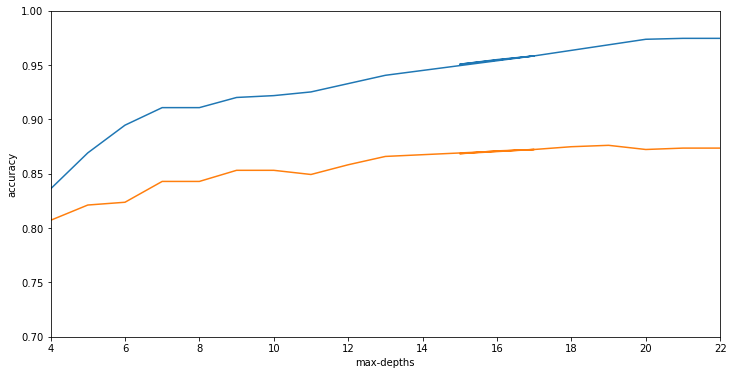

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))

x=[4,5,6,7,8,9,10,11,12,13,17,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

plt.plot(x, acc_tr, label = "train")
plt.plot(x, acc_tst, label = "test")

plt.xlabel('max-depths')
plt.ylabel('accuracy')

ax.set_ylim([0.7, 1])
ax.set_xlim([4, 22])

plt.show()

In [1]:
#show tree for max depth=19 (max test accuracy) = r[15]
#bosluk=0            
#show(r[15],bosluk)   